In [1]:
################################################################################################################
#Developed by Bahareh Kamali (1/7/2020) and adapted by Jonathan Ojeda 5/1/2021 QAAFI UQ
# Code functionalities:
# Calculate the main (ME) and total effect (TE) of a series of factors on the variability of a selected variable.

#ME explains the share of the components to crop yield variability without interactions, 
#i.e. if ME=1, the assessed factors explain the entire proportion of crop yield variability, 
#but if M<1, residuals exist which means additional factors are required to explain this variability. 
#TE represents the interaction of a given factor with other factors, i.e. high TE values for a given 
#factor denote high interactions of that factor with other factors, therefore, TE does not include residuals. 
#################################################################################################################

In [2]:
#Required packages
import os,csv,json,sys,shutil,random,glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import matplotlib.cm as cm
from matplotlib import colors
import matplotlib
from matplotlib.lines import Line2D
import math,zmq
from shutil import copyfile
global str
import datetime
import pandas as pd
import threading
import seaborn as sns

font = {'family' : 'verdana', 'size'   : 10}
matplotlib.rc('font', **font)
from math import sqrt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#Tool to minimize code and see only figures

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [4]:
#Get dataset
DATAA0 = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\tmp\var.csv')
df=DATAA0.drop(['Unnamed: 0'], axis=1)
DATAA1=df.dropna()

In [5]:
#Create Cluster of selected variables

#DATAA1['TempIn']=(DATAA1["tmax"]+DATAA1["tmin"])/2

thres1=np.percentile(DATAA1["TempIn"], 30)
thres2=np.percentile(DATAA1["TempIn"], 60)
DATAA1['TMPCluster']='Med'
DATAA1['TMPCluster'][DATAA1["TempIn"]<thres1]='Low'
DATAA1['TMPCluster'][DATAA1["TempIn"]>thres2]='High'

thres1=np.percentile(DATAA1["RainIn"], 30)
thres2=np.percentile(DATAA1["RainIn"],60)
DATAA1['RainInCluster']='Med'
DATAA1['RainInCluster'][DATAA1["RainIn"]<thres1]='Low'
DATAA1['RainInCluster'][DATAA1["RainIn"]>thres2]='High'

thres1=np.percentile(DATAA1["RadiationIn"], 30)
thres2=np.percentile(DATAA1["RadiationIn"], 60)
DATAA1['RadCluster']='Med'
DATAA1['RadCluster'][DATAA1["RadiationIn"]<thres1]='Low'
DATAA1['RadCluster'][DATAA1["RadiationIn"]>thres2]='High'

thres1=np.percentile(DATAA1["PAWC"], 30)
thres2=np.percentile(DATAA1["PAWC"], 60)
DATAA1['PAWCCluster']='Med'
DATAA1['PAWCCluster'][DATAA1["PAWC"]<thres1]='Low'
DATAA1['PAWCCluster'][DATAA1["PAWC"]>thres2]='High'

<ipython-input-5-20aa7af1d9c4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAA1['TMPCluster'][DATAA1["TempIn"]<thres1]='Low'
<ipython-input-5-20aa7af1d9c4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAA1['TMPCluster'][DATAA1["TempIn"]>thres2]='High'
<ipython-input-5-20aa7af1d9c4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAA1['RainInCluster'][DATAA1["RainIn"]<thres1]='Low'
<ipython-input-5-20aa7af1d9c4>:15: Set

In [6]:
#Create new categories and names
data1=DATAA1.groupby(["env_name","irr","cultivar","TMPCluster","RadCluster","RainInCluster","PAWCCluster"])['biomass'].mean().reset_index(name='biomass')

data1.loc[data1.cultivar == 0, 'cv'] = "GS"
data1.loc[data1.cultivar == 1, 'cv'] = "SS"
data1.loc[data1.cultivar == 2, 'cv'] = "FSPS"
data1.loc[data1.cultivar == 3, 'cv'] = "FS"

data1.loc[data1.irr == 1, 'irri'] = "R"
data1.loc[data1.irr == 2, 'irri'] = "I"

data1['cv_irri'] = data1['cv']+"_"+data1['irri']

data=data1.drop(['irr','cultivar'], axis=1)

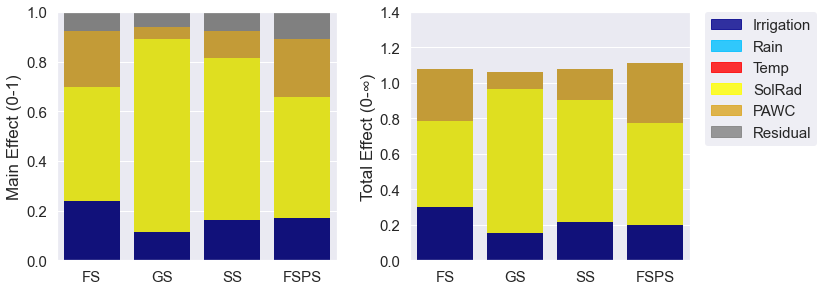

In [17]:
#Core code
South = data[data['env_name']=='South']
Components=["irri","RainInCluster",'TMPCluster','RadCluster','PAWCCluster']
cultivartype=['FS','GS','SS','FSPS']
c1,c2,c3,c4,c5=[],[],[],[],[]
for i in cultivartype:
    GridDATA=South[South['cv']==i]
    GridDATA=GridDATA.reset_index()
    GridDATA=GridDATA.drop( columns='cv')
    GridDATA=GridDATA.drop( columns='index')
    totalME=[]
    totalTE=[]
    for comp in Components:
        remaining_components=["irri","RainInCluster",'TMPCluster','RadCluster','PAWCCluster']    
        remaining_components.remove(comp)
        TS1_df=list(GridDATA.groupby(remaining_components)['biomass'].mean())
        TS1=1-(np.var(TS1_df)/np.var(list(GridDATA["biomass"])))
        
        TOF_df=list(GridDATA.groupby(comp)['biomass'].mean())
        TOP=(np.var(TOF_df)/np.var(list(GridDATA["biomass"])))
        
        c2.append(i)
        c3.append(comp)
        c4.append(TS1)
        c5.append(TOP)
        totalME.append(TOP)
        totalTE.append(TS1)
    # print(sum(totalME))
    # print(sum(totalTE))
                
Summary={'cultivartype':c2,
         'Components': c3,
         'Total Effect':c4,
         'Main Effect':c5}
TS_Summary=pd.DataFrame.from_dict(Summary)
#TS_Summary.to_csv('TS_Summary.csv')
fig  = plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.2, hspace=0.35,bottom=0.1, left=0.1, top=0.79,right=0.98)

TS_Summary1=TS_Summary[TS_Summary["Components"]=="irri"]
TS_Summary1=TS_Summary1.reset_index(drop=True)

TS_Summary2=TS_Summary[TS_Summary["Components"]=="RainInCluster"]
TS_Summary2=TS_Summary2.reset_index(drop=True)
TS_Summary2["Main Effect"]=TS_Summary2["Main Effect"]+TS_Summary1["Main Effect"]

TS_Summary3=TS_Summary[TS_Summary["Components"]=="TMPCluster"]
TS_Summary3=TS_Summary3.reset_index(drop=True)
TS_Summary3["Main Effect"]=TS_Summary3["Main Effect"]+TS_Summary2["Main Effect"]

TS_Summary4=TS_Summary[TS_Summary["Components"]=="RadCluster"]
TS_Summary4=TS_Summary4.reset_index(drop=True)
TS_Summary4["Main Effect"]=TS_Summary4["Main Effect"]+TS_Summary3["Main Effect"]

TS_Summary5=TS_Summary[TS_Summary["Components"]=="PAWCCluster"]
TS_Summary5=TS_Summary5.reset_index(drop=True)
TS_Summary5["Main Effect"]=TS_Summary5["Main Effect"]+TS_Summary4["Main Effect"]

TS_SummaryDic={'cultivartype':c2,
         'Components': c3,
         'Total Effect':np.ones(len(c2)),
         'Main Effect':np.ones(len(c2))}
TS_Summary6=pd.DataFrame.from_dict(TS_SummaryDic)

#######################
ax = plt.subplot(1,2,1)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary6, color = "grey", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary5, color = "goldenrod", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary4, color = "yellow", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary3, color = "red", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary2, color = "deepskyblue", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary1, color = "darkblue", linewidth=0)
#plt.title('Main Effect',fontsize=13)
plt.ylim([0,1])

orange_patch = mpatches.Patch(color='darkblue',alpha=.8,label='Irrigation')
blue_patch = mpatches.Patch(color='deepskyblue',alpha=.8,label='Rain')
red_patch = mpatches.Patch(color='red',alpha=.8,label='Temp')
violet_patch = mpatches.Patch(color='yellow',alpha=.8,label='SolRad')
green_patch = mpatches.Patch(color='goldenrod',alpha=.8,label='PAWC')
grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')

grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')
leg=plt.legend(handles=[orange_patch,blue_patch,red_patch,violet_patch,green_patch,grey_patch],fontsize=15,
               loc=4,ncol=1, bbox_to_anchor=[2.74, 0.43])   
leg.get_frame().set_linewidth(0.0)

plt.xlabel('')
plt.ylabel('Main Effect (0-1)',fontsize=17)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)

######################
ax = plt.subplot(1,2,2)
sns.set()

TS_Summary1=TS_Summary[TS_Summary["Components"]=="irri"]
TS_Summary1=TS_Summary1.reset_index(drop=True)

TS_Summary2=TS_Summary[TS_Summary["Components"]=="RainInCluster"]
TS_Summary2=TS_Summary2.reset_index(drop=True)
TS_Summary2["Total Effect"]=TS_Summary2["Total Effect"]+TS_Summary1["Total Effect"]

TS_Summary3=TS_Summary[TS_Summary["Components"]=="TMPCluster"]
TS_Summary3=TS_Summary3.reset_index(drop=True)
TS_Summary3["Total Effect"]=TS_Summary3["Total Effect"]+TS_Summary2["Total Effect"]

TS_Summary4=TS_Summary[TS_Summary["Components"]=="RadCluster"]
TS_Summary4=TS_Summary4.reset_index(drop=True)
TS_Summary4["Total Effect"]=TS_Summary4["Total Effect"]+TS_Summary3["Total Effect"]

TS_Summary5=TS_Summary[TS_Summary["Components"]=="PAWCCluster"]
TS_Summary5=TS_Summary5.reset_index(drop=True)
TS_Summary5["Total Effect"]=TS_Summary5["Total Effect"]+TS_Summary4["Total Effect"]

sns.barplot(x = 'cultivartype', y = 'Total Effect',data=TS_Summary5, color = "goldenrod", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Total Effect',data=TS_Summary4, color = "yellow", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Total Effect',data=TS_Summary3, color = "red", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Total Effect',data=TS_Summary2, color = "deepskyblue", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Total Effect',data=TS_Summary1, color = "darkblue", linewidth=0)
ax.set_ylim([0,1.4])

#plt.title('Total Effect',fontsize=13)
plt.xlabel('')
plt.ylabel('Total Effect (0-\u221E)',fontsize=17)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.26, hspace=0)
plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\South.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()

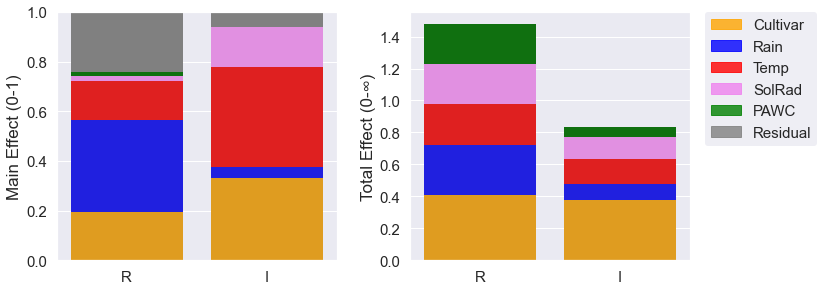

In [8]:
#Core code

Components=["cv","RainInCluster",'TMPCluster','RadCluster','PAWCCluster']
Irrigationtype=['R','I']
c1,c2,c3,c4,c5=[],[],[],[],[]

for i in Irrigationtype:
    GridDATA=data[data['irri']==i]
    GridDATA=GridDATA.reset_index()
    GridDATA=GridDATA.drop( columns='irri')
    GridDATA=GridDATA.drop( columns='index')
    totalME=[]
    totalTE=[]
    for comp in Components:
        remaining_components=["cv","RainInCluster",'TMPCluster','RadCluster','PAWCCluster']    
        remaining_components.remove(comp)
        TS1_df=list(GridDATA.groupby(remaining_components)['biomass'].mean())
        TS1=1-(np.var(TS1_df)/np.var(list(GridDATA["biomass"])))
        
        TOF_df=list(GridDATA.groupby(comp)['biomass'].mean())
        TOP=(np.var(TOF_df)/np.var(list(GridDATA["biomass"])))
        
        c2.append(i)
        c3.append(comp)
        c4.append(TS1)
        c5.append(TOP)
        totalME.append(TOP)
        totalTE.append(TS1)
    # print(sum(totalME))
    # print(sum(totalTE))
                
Summary={'Irrigationtype':c2,
         'Components': c3,
         'Total Effect':c4,
         'Main Effect':c5}
TS_Summary=pd.DataFrame.from_dict(Summary)
#TS_Summary.to_csv('TS_Summary.csv')

fig  = plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.2, hspace=0.35,bottom=0.1, left=0.1, top=0.79,right=0.98)

TS_Summary1=TS_Summary[TS_Summary["Components"]=="cv"]
TS_Summary1=TS_Summary1.reset_index(drop=True)

TS_Summary2=TS_Summary[TS_Summary["Components"]=="RainInCluster"]
TS_Summary2=TS_Summary2.reset_index(drop=True)
TS_Summary2["Main Effect"]=TS_Summary2["Main Effect"]+TS_Summary1["Main Effect"]

TS_Summary3=TS_Summary[TS_Summary["Components"]=="TMPCluster"]
TS_Summary3=TS_Summary3.reset_index(drop=True)
TS_Summary3["Main Effect"]=TS_Summary3["Main Effect"]+TS_Summary2["Main Effect"]

TS_Summary4=TS_Summary[TS_Summary["Components"]=="RadCluster"]
TS_Summary4=TS_Summary4.reset_index(drop=True)
TS_Summary4["Main Effect"]=TS_Summary4["Main Effect"]+TS_Summary3["Main Effect"]

TS_Summary5=TS_Summary[TS_Summary["Components"]=="PAWCCluster"]
TS_Summary5=TS_Summary5.reset_index(drop=True)
TS_Summary5["Main Effect"]=TS_Summary5["Main Effect"]+TS_Summary4["Main Effect"]

TS_SummaryDic={'Irrigationtype':c2,
         'Components': c3,
         'Total Effect':np.ones(len(c2)),
         'Main Effect':np.ones(len(c2))}
TS_Summary6=pd.DataFrame.from_dict(TS_SummaryDic)

#######################
ax = plt.subplot(1,2,1)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary6, color = "grey", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary5, color = "green", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary4, color = "violet", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary3, color = "red", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary2, color = "blue", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary1, color = "orange", linewidth=0)
#plt.title('Main Effect',fontsize=13)
plt.ylim([0,1])

orange_patch = mpatches.Patch(color='orange',alpha=.8,label='Cultivar')
blue_patch = mpatches.Patch(color='blue',alpha=.8,label='Rain')
red_patch = mpatches.Patch(color='red',alpha=.8,label='Temp')
violet_patch = mpatches.Patch(color='violet',alpha=.8,label='SolRad')
green_patch = mpatches.Patch(color='green',alpha=.8,label='PAWC')
grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')

leg=plt.legend(handles=[orange_patch,blue_patch,red_patch,violet_patch,green_patch,grey_patch],fontsize=15,
               loc=4,ncol=1, bbox_to_anchor=[2.74, 0.43])   
leg.get_frame().set_linewidth(0.0)

plt.xlabel('')
plt.ylabel('Main Effect (0-1)',fontsize=17)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)

######################
ax = plt.subplot(1,2,2)
sns.set()

TS_Summary1=TS_Summary[TS_Summary["Components"]=="cv"]
TS_Summary1=TS_Summary1.reset_index(drop=True)

TS_Summary2=TS_Summary[TS_Summary["Components"]=="RainInCluster"]
TS_Summary2=TS_Summary2.reset_index(drop=True)
TS_Summary2["Total Effect"]=TS_Summary2["Total Effect"]+TS_Summary1["Total Effect"]

TS_Summary3=TS_Summary[TS_Summary["Components"]=="TMPCluster"]
TS_Summary3=TS_Summary3.reset_index(drop=True)
TS_Summary3["Total Effect"]=TS_Summary3["Total Effect"]+TS_Summary2["Total Effect"]

TS_Summary4=TS_Summary[TS_Summary["Components"]=="RadCluster"]
TS_Summary4=TS_Summary4.reset_index(drop=True)
TS_Summary4["Total Effect"]=TS_Summary4["Total Effect"]+TS_Summary3["Total Effect"]

TS_Summary5=TS_Summary[TS_Summary["Components"]=="PAWCCluster"]
TS_Summary5=TS_Summary5.reset_index(drop=True)
TS_Summary5["Total Effect"]=TS_Summary5["Total Effect"]+TS_Summary4["Total Effect"]

sns.barplot(x = 'Irrigationtype', y = 'Total Effect',data=TS_Summary5, color = "green", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Total Effect',data=TS_Summary4, color = "violet", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Total Effect',data=TS_Summary3, color = "red", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Total Effect',data=TS_Summary2, color = "blue", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Total Effect',data=TS_Summary1, color = "orange", linewidth=0)
#plt.title('Total Effect',fontsize=13)
plt.xlabel('')
plt.ylabel('Total Effect (0-\u221E)',fontsize=17)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.26, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\figs\decomp.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()

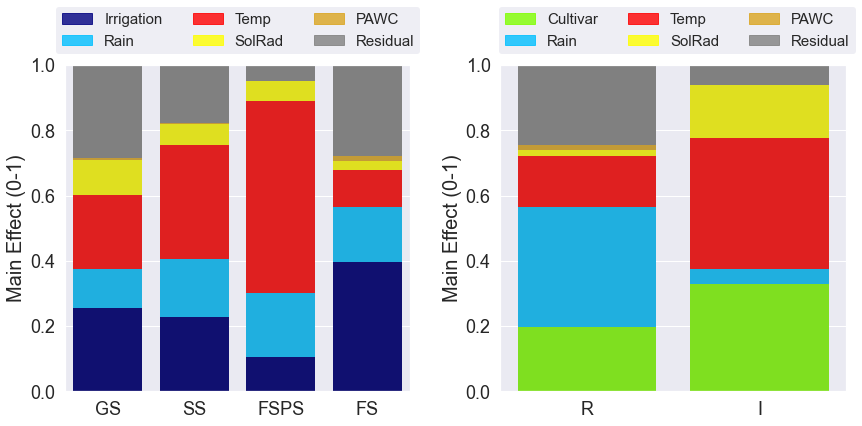

In [9]:
#Core code (plot only ME for cultivar and irrigation categories)

###########################################################################
Components=["irri","RainInCluster",'TMPCluster','RadCluster','PAWCCluster']
cultivartype=['GS','SS','FSPS','FS']
c1,c2,c3,c4,c5=[],[],[],[],[]
for i in cultivartype:
    GridDATA=data[data['cv']==i]
    GridDATA=GridDATA.reset_index()
    GridDATA=GridDATA.drop( columns='cv')
    GridDATA=GridDATA.drop( columns='index')
    totalME=[]
    totalTE=[]
    for comp in Components:
        remaining_components=["irri","RainInCluster",'TMPCluster','RadCluster','PAWCCluster']    
        remaining_components.remove(comp)
        TS1_df=list(GridDATA.groupby(remaining_components)['biomass'].mean())
        TS1=1-(np.var(TS1_df)/np.var(list(GridDATA["biomass"])))
        
        TOF_df=list(GridDATA.groupby(comp)['biomass'].mean())
        TOP=(np.var(TOF_df)/np.var(list(GridDATA["biomass"])))
        
        c2.append(i)
        c3.append(comp)
        c4.append(TS1)
        c5.append(TOP)
        totalME.append(TOP)
        totalTE.append(TS1)
    # print(sum(totalME))
    # print(sum(totalTE))
                
Summary={'cultivartype':c2,
         'Components': c3,
         'Total Effect':c4,
         'Main Effect':c5}
TS_Summary=pd.DataFrame.from_dict(Summary)
#TS_Summary.to_csv('TS_Summary.csv')

TS_Summary1a=TS_Summary[TS_Summary["Components"]=="irri"]
TS_Summary1a=TS_Summary1a.reset_index(drop=True)

TS_Summary2a=TS_Summary[TS_Summary["Components"]=="RainInCluster"]
TS_Summary2a=TS_Summary2a.reset_index(drop=True)
TS_Summary2a["Main Effect"]=TS_Summary2a["Main Effect"]+TS_Summary1a["Main Effect"]

TS_Summary3a=TS_Summary[TS_Summary["Components"]=="TMPCluster"]
TS_Summary3a=TS_Summary3a.reset_index(drop=True)
TS_Summary3a["Main Effect"]=TS_Summary3a["Main Effect"]+TS_Summary2a["Main Effect"]

TS_Summary4a=TS_Summary[TS_Summary["Components"]=="RadCluster"]
TS_Summary4a=TS_Summary4a.reset_index(drop=True)
TS_Summary4a["Main Effect"]=TS_Summary4a["Main Effect"]+TS_Summary3a["Main Effect"]

TS_Summary5a=TS_Summary[TS_Summary["Components"]=="PAWCCluster"]
TS_Summary5a=TS_Summary5a.reset_index(drop=True)
TS_Summary5a["Main Effect"]=TS_Summary5a["Main Effect"]+TS_Summary4a["Main Effect"]

TS_SummaryDic={'cultivartype':c2,
         'Components': c3,
         'Total Effect':np.ones(len(c2)),
         'Main Effect':np.ones(len(c2))}
TS_Summary6a=pd.DataFrame.from_dict(TS_SummaryDic)

#########################################################################
Components=["cv","RainInCluster",'TMPCluster','RadCluster','PAWCCluster']
Irrigationtype=['R','I']
c1,c2,c3,c4,c5=[],[],[],[],[]

for i in Irrigationtype:
    GridDATA=data[data['irri']==i]
    GridDATA=GridDATA.reset_index()
    GridDATA=GridDATA.drop( columns='irri')
    GridDATA=GridDATA.drop( columns='index')
    totalME=[]
    totalTE=[]
    for comp in Components:
        remaining_components=["cv","RainInCluster",'TMPCluster','RadCluster','PAWCCluster']    
        remaining_components.remove(comp)
        TS1_df=list(GridDATA.groupby(remaining_components)['biomass'].mean())
        TS1=1-(np.var(TS1_df)/np.var(list(GridDATA["biomass"])))
        
        TOF_df=list(GridDATA.groupby(comp)['biomass'].mean())
        TOP=(np.var(TOF_df)/np.var(list(GridDATA["biomass"])))
        
        c2.append(i)
        c3.append(comp)
        c4.append(TS1)
        c5.append(TOP)
        totalME.append(TOP)
        totalTE.append(TS1)
    # print(sum(totalME))
    # print(sum(totalTE))
                
Summary={'Irrigationtype':c2,
         'Components': c3,
         'Total Effect':c4,
         'Main Effect':c5}
TS_Summary=pd.DataFrame.from_dict(Summary)
#TS_Summary.to_csv('TS_Summary.csv')

TS_Summary1b=TS_Summary[TS_Summary["Components"]=="cv"]
TS_Summary1b=TS_Summary1b.reset_index(drop=True)

TS_Summary2b=TS_Summary[TS_Summary["Components"]=="RainInCluster"]
TS_Summary2b=TS_Summary2b.reset_index(drop=True)
TS_Summary2b["Main Effect"]=TS_Summary2b["Main Effect"]+TS_Summary1b["Main Effect"]

TS_Summary3b=TS_Summary[TS_Summary["Components"]=="TMPCluster"]
TS_Summary3b=TS_Summary3b.reset_index(drop=True)
TS_Summary3b["Main Effect"]=TS_Summary3b["Main Effect"]+TS_Summary2b["Main Effect"]

TS_Summary4=TS_Summary[TS_Summary["Components"]=="RadCluster"]
TS_Summary4b=TS_Summary4.reset_index(drop=True)
TS_Summary4b["Main Effect"]=TS_Summary4b["Main Effect"]+TS_Summary3b["Main Effect"]

TS_Summary5b=TS_Summary[TS_Summary["Components"]=="PAWCCluster"]
TS_Summary5b=TS_Summary5b.reset_index(drop=True)
TS_Summary5b["Main Effect"]=TS_Summary5b["Main Effect"]+TS_Summary4b["Main Effect"]

TS_SummaryDic={'Irrigationtype':c2,
         'Components': c3,
         'Total Effect':np.ones(len(c2)),
         'Main Effect':np.ones(len(c2))}
TS_Summary6b=pd.DataFrame.from_dict(TS_SummaryDic)

#######################
#FIGURE#
#######################
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary6a, color = "grey", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary5a, color = "goldenrod", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary4a, color = "yellow", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary3a, color = "red", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary2a, color = "deepskyblue", linewidth=0)
sns.barplot(x = 'cultivartype', y = 'Main Effect',data=TS_Summary1a, color = "navy", linewidth=0)
#plt.title('Main Effect',fontsize=13)
plt.ylim([0,1])

orange_patch = mpatches.Patch(color='navy',alpha=.8,label='Irrigation')
blue_patch = mpatches.Patch(color='deepskyblue',alpha=.8,label='Rain')
red_patch = mpatches.Patch(color='red',alpha=.8,label='Temp')
violet_patch = mpatches.Patch(color='yellow',alpha=.8,label='SolRad')
green_patch = mpatches.Patch(color='goldenrod',alpha=.8,label='PAWC')
grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')

grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')
leg=plt.legend(handles=[orange_patch,blue_patch,red_patch,violet_patch,green_patch,grey_patch],fontsize=15,
               loc=4,ncol=3, bbox_to_anchor=[1.05, 1.01])   
leg.get_frame().set_linewidth(0.0)

plt.xlabel('')
plt.ylabel('Main Effect (0-1)',fontsize=20)
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=18)

ax = plt.subplot(1,2,2)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary6b, color = "grey", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary5b, color = "goldenrod", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary4b, color = "yellow", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary3b, color = "red", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary2b, color = "deepskyblue", linewidth=0)
sns.barplot(x = 'Irrigationtype', y = 'Main Effect',data=TS_Summary1b, color = "chartreuse", linewidth=0)
#plt.title('Main Effect',fontsize=13)
plt.ylim([0,1])

orange_patch = mpatches.Patch(color='chartreuse',alpha=.8,label='Cultivar')
blue_patch = mpatches.Patch(color='deepskyblue',alpha=.8,label='Rain')
red_patch = mpatches.Patch(color='red',alpha=.8,label='Temp')
violet_patch = mpatches.Patch(color='yellow',alpha=.8,label='SolRad')
green_patch = mpatches.Patch(color='goldenrod',alpha=.8,label='PAWC')
grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')

leg=plt.legend(handles=[orange_patch,blue_patch,red_patch,violet_patch,green_patch,grey_patch],fontsize=15,
               loc=4,ncol=3, bbox_to_anchor=[1.05, 1.01]) 
leg.get_frame().set_linewidth(0.0)

plt.xlabel('')
plt.ylabel('Main Effect (0-1)',fontsize=20)
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=18)

plt.subplots_adjust(wspace=0.26, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\figs\decomp.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()

In [10]:
data

,env_name,TMPCluster,RadCluster,RainInCluster,PAWCCluster,biomass,cv,irri,cv_irri
0,East,High,Low,High,High,13255.996333,GS,R,GS_R
1,East,High,Low,High,Low,11949.653887,GS,R,GS_R
2,East,High,Low,High,Med,12442.641333,GS,R,GS_R
3,East,High,Low,Med,Low,11552.262800,GS,R,GS_R
4,East,High,Med,High,Low,12057.285875,GS,R,GS_R
...,...,...,...,...,...,...,...,...,...
811,West,Low,High,Low,High,19023.110000,FS,I,FS_I
812,West,Low,High,Low,Med,18524.267625,FS,I,FS_I
813,West,Med,High,Low,High,20403.649512,FS,I,FS_I
814,West,Med,High,Low,Low,19919.688714,FS,I,FS_I


0.6911391147589262
0.7733338995552379
0.7733338995552379
1.0039797049443306
0.7457199581486817
0.8321819397214636
0.8321819397214636
1.040314072058808
0.8302189522297806
0.9355908063303313
0.9355908063303313
1.1189120771473855
0.8071676382673748
0.9940299516332518
0.9940299516332518
1.1375942119716242
0.0040575881982542715
1.1267016834223889
1.1267016834223889
1.1275118140205138
0.22185524166732673
0.5305432999735276
0.5305432999735276
0.847339187932016
0.4050691141063344
1.2897995215756937
1.2897995215756937
1.3127209611898147
0.5653522534204298
1.3303959801029828
1.3303959801029828
1.352881092408248


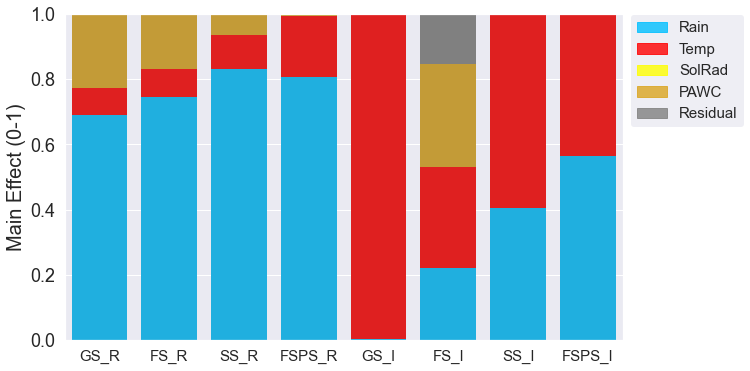

In [12]:
#########################################################################
#Plotting bu cv_irri category
#########################################################################
West = data[data['env_name']=='West']
Components=["RainInCluster",'TMPCluster','RadCluster','PAWCCluster']
cv_irritype=['GS_R', 'FS_R', 'SS_R', 'FSPS_R', 'GS_I', 'FS_I', 'SS_I', 'FSPS_I']
c1,c2,c3,c4=[],[],[],[]

for i in cv_irritype:
    GridDATA=West[West['cv_irri']==i]
    GridDATA=GridDATA.reset_index()
    GridDATA=GridDATA.drop( columns='cv_irri')
    GridDATA=GridDATA.drop( columns='index')
    totalME=[]
    totalTE=[]
    for comp in Components:
        remaining_components=["RainInCluster",'TMPCluster','RadCluster','PAWCCluster']    
        remaining_components.remove(comp)
        TS1_df=list(GridDATA.groupby(remaining_components)['biomass'].mean())
        TS1=1-(np.var(TS1_df)/np.var(list(GridDATA["biomass"])))
        
        TOF_df=list(GridDATA.groupby(comp)['biomass'].mean())
        TOP=(np.var(TOF_df)/np.var(list(GridDATA["biomass"])))
        
        c1.append(i)
        c2.append(comp)
        c3.append(TS1)
        c4.append(TOP)
        totalME.append(TOP)
        totalTE.append(TS1)
        print(sum(totalME))
    # print(sum(totalTE))
                
Summary={'cv_irritype':c1,
         'Components': c2,
         'Total Effect':c3,
         'Main Effect':c4}
TS_Summary=pd.DataFrame.from_dict(Summary)
#TS_Summary.to_csv('TS_Summary.csv')

TS_Summary1=TS_Summary[TS_Summary["Components"]=="RainInCluster"]
TS_Summary1=TS_Summary1.reset_index(drop=True)

TS_Summary2=TS_Summary[TS_Summary["Components"]=="TMPCluster"]
TS_Summary2=TS_Summary2.reset_index(drop=True)
TS_Summary2["Main Effect"]=TS_Summary2["Main Effect"]+TS_Summary1["Main Effect"]

TS_Summary3=TS_Summary[TS_Summary["Components"]=="RadCluster"]
TS_Summary3=TS_Summary3.reset_index(drop=True)
TS_Summary3["Main Effect"]=TS_Summary3["Main Effect"]+TS_Summary2["Main Effect"]

TS_Summary4=TS_Summary[TS_Summary["Components"]=="PAWCCluster"]
TS_Summary4=TS_Summary4.reset_index(drop=True)
TS_Summary4["Main Effect"]=TS_Summary4["Main Effect"]+TS_Summary3["Main Effect"]

TS_SummaryDic={'cv_irritype':c1,
         'Components': c2,
         'Total Effect':np.ones(len(c1)),
         'Main Effect':np.ones(len(c1))}
TS_Summary5=pd.DataFrame.from_dict(TS_SummaryDic)

#######################
#FIGURE#
#######################
fig = plt.figure(figsize=(10,6))

ax = plt.subplot(1,1,1)
sns.barplot(x = 'cv_irritype', y = 'Main Effect',data=TS_Summary5, color = "grey", linewidth=0)
sns.barplot(x = 'cv_irritype', y = 'Main Effect',data=TS_Summary4, color = "goldenrod", linewidth=0)
sns.barplot(x = 'cv_irritype', y = 'Main Effect',data=TS_Summary3, color = "yellow", linewidth=0)
sns.barplot(x = 'cv_irritype', y = 'Main Effect',data=TS_Summary2, color = "red", linewidth=0)
sns.barplot(x = 'cv_irritype', y = 'Main Effect',data=TS_Summary1, color = "deepskyblue", linewidth=0)
#plt.title('Main Effect',fontsize=13)
plt.ylim([0,1])

blue_patch = mpatches.Patch(color='deepskyblue',alpha=.8,label='Rain')
red_patch = mpatches.Patch(color='red',alpha=.8,label='Temp')
violet_patch = mpatches.Patch(color='yellow',alpha=.8,label='SolRad')
green_patch = mpatches.Patch(color='goldenrod',alpha=.8,label='PAWC')
grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')

leg=plt.legend(handles=[blue_patch,red_patch,violet_patch,green_patch,grey_patch],fontsize=15,
               loc=4,ncol=1, bbox_to_anchor=[1.23, 0.63])   
leg.get_frame().set_linewidth(0.0)

plt.xlabel('')
plt.ylabel('Main Effect (0-1)',fontsize=20)
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.26, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\figs\decomp.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()